<a href="https://colab.research.google.com/github/pavelpryadokhin/Transformer-BERT-GPT/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Построим трансформер для для задачи question answering. Трансформер будет работать по принципу чат-бота: принимать на вход вопрос, и генерировать ответ на этот вопрос. Будем использовать датасет с [HuggingFace](https://huggingface.co/datasets/Den4ikAI/russian_dialogues).

#Предобработка данных и загрузка словаря

In [ ]:
# Установим свежую версию TensorFlow для поддержки слоя `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install datasets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcudnn8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.17.0 requires keras>=3.2.0, which is not installed.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.17.0 requires keras>=3.2.0, which is not installed.
tensorflow-tpu 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.17.0 req

In [ ]:
# Логирование для отладки
import logging

# Замеры времени выполнения
import time

# Линейная алгебра
import numpy as np

# Вывод графиков
import matplotlib.pyplot as plt

# Фреймворк Tensorflow
import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
# Регулярные выражения
import re

# Файловая система
import pathlib

# Токенизатор
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datasets import load_dataset

dataset = load_dataset('Den4ikAI/russian_dialogues', split='train', )
print(len(dataset))
dataset = dataset.filter(lambda x:all(x[field] is not None for field in ['question', 'answer']))
print(len(dataset))

README.md:   0%|          | 0.00/951 [00:00<?, ?B/s]

dataset.jsonl:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2477321 [00:00<?, ? examples/s]

2477321


Filter:   0%|          | 0/2477321 [00:00<?, ? examples/s]

2476083


In [ ]:
def prepare_dataset(dataset, test_size=0.2, shuffle_seed=42,ex=65000):

    # Разделение на обучающую и тестовую выборки
    train_test_split = dataset.select(range(ex)).train_test_split(test_size=test_size)

    train_dataset = train_test_split['train'].shuffle(seed=shuffle_seed)
    test_dataset = train_test_split['test'].shuffle(seed=shuffle_seed)

    # Получение X и y
    X_train = train_dataset['question']
    y_train = train_dataset['answer']

    X_test = test_dataset['question']
    y_test = test_dataset['answer']

    # Преобразование в тензоры TensorFlow
    train_tensor = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))
    test_tensor = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)))

    return train_tensor, test_tensor

# Пример использования
train_dataset, val_dataset = prepare_dataset(dataset)

# Проверка размеров выборок
print(f'Размер обучающего датасета: {train_dataset.cardinality().numpy()}')
print(f'Размер тестового датасета: {val_dataset.cardinality().numpy()}')


Размер обучающего датасета: 52000
Размер тестового датасета: 13000


In [ ]:
for question, answer in train_dataset.batch(3).take(1):
    print('Вопрос:')
    print()
    print(question.numpy()[0].decode('utf-8'))
    print()

    print('Ответ:')
    print()
    print(answer.numpy()[0].decode('utf-8'))

Вопрос:

о чем можна мечтать вглядываясь в океан звезд?

Ответ:

я мечтаю о том, чтобы одну из звезд назвать женским именем и подарить любимой.


In [ ]:
VOCAB_SIZE = 8000
bert_tokenizer_params=dict(lower_case=True)

# [START] - начало строки
# [END]   - конец строки
# [UNK]   - неизвестное слово
# [PAD]   - используется для выравнивания длин всех предложений
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    vocab_size = VOCAB_SIZE,
    reserved_tokens=reserved_tokens,
    bert_tokenizer_params=bert_tokenizer_params,
    learn_params={},
)

In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

def vocab(data,bert_vocab_args):
    train_x = data.map(lambda x,y: x)
    train_y = data.map(lambda x,y: y)

    x_vocab = bert_vocab.bert_vocab_from_dataset(
    train_x.batch(1000).prefetch(2),
    **bert_vocab_args)

    y_vocab = bert_vocab.bert_vocab_from_dataset(
    train_y.batch(1000).prefetch(2),
    **bert_vocab_args)

    return x_vocab,y_vocab

x_train_vocab,y_train_vocab = vocab(train_dataset,bert_vocab_args)

print(x_train_vocab[:10])

In [ ]:
# сохраним словари
write_vocab_file('x_train_vocab.txt', x_train_vocab)
write_vocab_file('y_train_vocab.txt', y_train_vocab)

In [ ]:
# загрузим словари
x_tokenizer = text.BertTokenizer('x_train_vocab.txt', **bert_tokenizer_params)
y_tokenizer = text.BertTokenizer('y_train_vocab.txt', **bert_tokenizer_params)

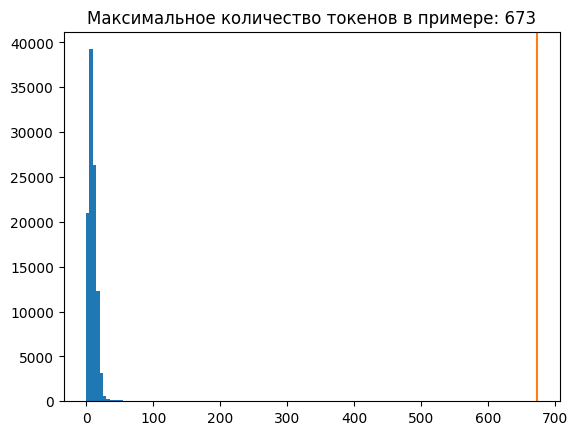

In [ ]:
lengths = []
for x,y in train_dataset.batch(1000):
    x_tokens = x_tokenizer.tokenize(x)
    lengths.append(x_tokens.row_lengths())

    y_tokens = y_tokenizer.tokenize(y)
    lengths.append(y_tokens.row_lengths())

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Максимальное количество токенов в примере: {max_length}');

Проанализировав график определим максимальную длину фраз

In [ ]:
MAX_TOKENS=50

#Токенизатор

In [ ]:
class CustomTokenizer(tf.Module):
    def __init__(self, reserved_tokens, vocab_path):

        self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
        self._reserved_tokens = reserved_tokens
        self._vocab_path = tf.saved_model.Asset(vocab_path)
        # Читаем из файла словарь и делим по строкам
        vocab = pathlib.Path(vocab_path).read_text().splitlines()
        self.vocab = tf.Variable(vocab)

        # Сигнатура для tokenize (работает с пакетами строк).
        self.tokenize.get_concrete_function(
            tf.TensorSpec(shape=[None], dtype=tf.string))


        self.detokenize.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))
        self.detokenize.get_concrete_function(
            tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

        self.lookup.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))
        self.lookup.get_concrete_function(
            tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

        self.get_vocab_size.get_concrete_function()
        self.get_vocab_path.get_concrete_function()
        self.get_reserved_tokens.get_concrete_function()

    def add_start_end(self, ragged):
        START = tf.argmax(tf.constant(self._reserved_tokens) == "[START]")
        END = tf.argmax(tf.constant(self._reserved_tokens) == "[END]")
        count = ragged.bounding_shape()[0]
        starts = tf.fill([count,1], START)
        ends = tf.fill([count,1], END)
        return tf.concat([starts, ragged, ends], axis=1)

    def cleanup_text(self, reserved_tokens, token_txt):
        bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
        bad_token_re = "|".join(bad_tokens)
        bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
        result = tf.ragged.boolean_mask(token_txt, ~bad_cells)
        result = tf.strings.reduce_join(result, separator=' ', axis=-1)
        return result

    @tf.function
    def tokenize(self, strings):
        enc = self.tokenizer.tokenize(strings)
        enc = enc.merge_dims(-2,-1)
        enc = self.add_start_end(enc)
        return enc

    @tf.function
    def detokenize(self, tokenized):
        words = self.tokenizer.detokenize(tokenized)
        return self.cleanup_text(self._reserved_tokens, words) # очищаем перед выводом

    @tf.function
    def lookup(self, token_ids):
        return tf.gather(self.vocab, token_ids) # возвращаем явное соответствие словаря токенам

    @tf.function
    def get_vocab_size(self):
        return tf.shape(self.vocab)[0] # определяем длину словаря по нулевому индексу формы

    @tf.function
    def get_vocab_path(self):
        return self._vocab_path # получение пути к файлу словаря

    @tf.function
    def get_reserved_tokens(self):
        return tf.constant(self._reserved_tokens) # получение списка зарезервированных токенов


In [ ]:
tokenizers = tf.Module()
tokenizers.x = CustomTokenizer(reserved_tokens, 'x_train_vocab.txt')
tokenizers.y = CustomTokenizer(reserved_tokens, 'y_train_vocab.txt')

In [ ]:
model_name = 'russian_dialogues_answer+question'
tf.saved_model.save(tokenizers, model_name)

Проверим работу токенизатора

In [ ]:
encoded = tokenizers.y.tokenize(answer)
for row in encoded.to_list():
  print(row)

print()
round_trip = tokenizers.y.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

[2, 67, 2563, 50, 236, 5, 132, 1120, 119, 44, 1292, 3495, 1863, 7161, 1654, 228, 4748, 90, 45, 1364, 1119, 7, 3]
[2, 1634, 6, 120, 795, 953, 159, 68, 2610, 447, 691, 39, 128, 5, 2460, 7329, 7, 3]
[2, 75, 55, 2460, 39, 2100, 74, 149, 7, 72, 45, 2651, 503, 81, 99, 3]

я мечтаю о том , чтобы одну из звезд назвать женским именем и подарить любимои .
ревность - вымысел неверующих в себя , обоих полов .
если у обоих в итоге все хорошо . то и встреча приятнои будет


# Подготовка датасета, предобработка данных

In [ ]:
def prepare_batch(x,y):
    x = tokenizers.x.tokenize(x)
    x = x[:, :MAX_TOKENS]           # Выравнивание данных по MAX_TOKENS.
    x = x.to_tensor()               # Преобразуем в тензор с равномерными измерениями

    y = tokenizers.y.tokenize(y)
    y = y[:, :(MAX_TOKENS+1)]
    y_inputs = y[:, :-1].to_tensor()  # Удаляем [END] токены (вход декодировщика)
    y_labels = y[:, 1:].to_tensor()   # Удаляем [START] токены (выход декодировщика)

    return (x, y_inputs), y_labels

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)                     # перемешиваем данные
      .batch(BATCH_SIZE)                        # делим датасет на пакеты
      .map(prepare_batch, tf.data.AUTOTUNE)     # применим функцию prepare_batch
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

for (x, y), y_labels in train_batches.take(1):
  break

print(x.shape)
print(y.shape)
print(y_labels.shape)

(64, 41)
(64, 31)
(64, 31)


#Модель Трансформера

##Позиционное кодирование

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(length=2048, depth=512)
pos_encoding.shape

TensorShape([2048, 512])

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x


In [ ]:
# тест
embed_x = PositionalEmbedding(vocab_size=tokenizers.x.get_vocab_size().numpy(), d_model=512)
embed_y = PositionalEmbedding(vocab_size=tokenizers.y.get_vocab_size().numpy(), d_model=512)

x_emb = embed_x(x)
y_emb = embed_y(y)
x_emb._keras_mask

<tf.Tensor: shape=(64, 41), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

##Классы внимания

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [ ]:
# тест
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(x_emb.shape)
print(y_emb.shape)
print(sample_ca(y_emb, x_emb).shape)

(64, 41, 512)
(64, 31, 512)
(64, 31, 512)


In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
# тест
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(x_emb.shape)
print(sample_gsa(x_emb).shape)

(64, 41, 512)
(64, 41, 512)


In [ ]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
# тест
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(y_emb.shape)
print(sample_csa(y_emb).shape)

(64, 31, 512)
(64, 31, 512)


##Сеть прямого распространения

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [ ]:
# тест
sample_ffn = FeedForward(512, 2048)

print(y_emb.shape)
print(sample_ffn(y_emb).shape)

(64, 31, 512)
(64, 31, 512)


##Сбор  сети

###Кодировщик

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [ ]:
# тест
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(x_emb.shape)
print(sample_encoder_layer(x_emb).shape)

(64, 41, 512)
(64, 41, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x

In [ ]:
# тест
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(x, training=False)

print(x.shape)
print(sample_encoder_output.shape)

(64, 41)
(64, 41, 512)


###Декодировщик

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x

In [ ]:
# тест
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=y_emb, context=x_emb)

print(y_emb.shape)
print(x_emb.shape)
print(sample_decoder_layer_output.shape)

(64, 31, 512)
(64, 41, 512)
(64, 31, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size,dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x

In [ ]:
# тест
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(x=y,context=x_emb)

print(y.shape)
print(x_emb.shape)
print(output.shape)
sample_decoder.last_attn_scores.shape

(64, 31)
(64, 41, 512)
(64, 31, 512)


TensorShape([64, 8, 31, 41])

###Вместе

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=input_vocab_size,
                            dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=target_vocab_size,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x  = inputs
        context = self.encoder(context)
        x = self.decoder(x, context)
        logits = self.final_layer(x)
        try:
            del logits._keras_mask
        except AttributeError: pass
        return logits

#Обучение

Зададим параметры для трансформера

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 6
dropout_rate = 0.1

EPOCHS = 5

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.x.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.y.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
# тест
output = transformer((x, y))

print(y.shape)
print(x.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)

(64, 31)
(64, 41)
(64, 31, 7493)
(64, 6, 31, 41)


Зададим оптимизатор Adam с настраиваемым планировщиком скорости обучения в соответствии с формулой(взятой из статьи [Attention Is All You Need](https://arxiv.org/pdf/1706.03762))

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Реализуем функцию потерь

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

813/813 ━━━━━━━━━━━━━━━━━━━━ 6827s 8s/step - loss: 8.0026 - masked_accuracy: 0.0561 - val_loss: 6.1360 - val_masked_accuracy: 0.1110


In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

813/813 ━━━━━━━━━━━━━━━━━━━━ 6786s 8s/step - loss: 5.9556 - masked_accuracy: 0.1181 - val_loss: 5.6200 - val_masked_accuracy: 0.1300


#Inference

In [ ]:
class Dialog(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
        sentence = self.tokenizers.x.tokenize(sentence).to_tensor()
        encoder_input = sentence

        start_end = self.tokenizers.y.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)
            predictions = predictions[:, -1:, :]
            predicted_id = tf.argmax(predictions, axis=-1)
            output_array = output_array.write(i+1, predicted_id[0])
            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        text = tokenizers.y.detokenize(output)[0]
        tokens = tokenizers.y.lookup(output)[0]
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [ ]:
dialog = Dialog(tokenizers, transformer)

In [ ]:
def chat(text,model=dialog):
    text, tokens, attention_weights = model(tf.constant(text))
    return text.numpy().decode("utf-8")

In [ ]:
chat('Что ты любишь?')

'я не люблю , но я не люблю'

In [ ]:
chat('Что ты знаешь?')

'я не спрара'

#Сохраним модель

In [ ]:
class ExportDialog(tf.Module):
  def __init__(self, translator):
    self.dialog = dialog

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,tokens,attention_weights) = self.dialog(sentence, max_length=MAX_TOKENS)
    return result

In [ ]:
dialog = ExportDialog(dialog)

In [ ]:
tf.saved_model.save(dialog, export_dir='dialog')

Згрузить обратно

In [ ]:
reloaded = tf.saved_model.load('dialog')

#Резюме

Мы создали модель трансформера и обучили её на наборе данных с диалогами. Результаты оказались удовлетворительными, но модель показала точность всего 11%. Чтобы улучшить понимание контекста, нам нужны ресурсы, которые не предоставляет бесплатная среда Colab.